# Twitter

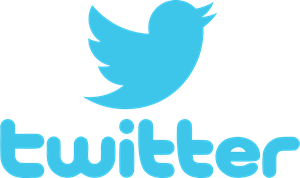

Twitter API allows to fetch live tweets by keyword, or to fetch a 1/6th sample of all twitter traffic.

### Setting up Twitter Credentials

* go to https://apps.twitter.com/
* Apply for a (personal) twitter developer account
* Create a new project
* "Keys and Access Tokens"
* save four keys into `.env` file (or copy `sample.env` to `.env` first)
    * `CONSUMER_KEY` = Consumer Key (API Key)
    * `CONSUMER_SECRET` = Consumer Secret (API Secret)
    * `TWITTER_TOKEN` = Access Token
    * `TWITTER_SECRET` = Access Token Secret

### Getting Started

In [2]:
import os

from dotenv import load_dotenv
load_dotenv()

CONSUMER_KEY = os.environ['CONSUMER_KEY']
CONSUMER_SECRET = os.environ['CONSUMER_SECRET']
TWITTER_TOKEN = os.environ['TWITTER_TOKEN']
TWITTER_SECRET = os.environ['TWITTER_SECRET']

In [3]:
import re

import twitter

# create new twitter stream
stream = twitter.TwitterStream(
    timeout=3600,
    heartbeat_timeout=3600,
    auth=twitter.OAuth(TWITTER_TOKEN,
                       TWITTER_SECRET,
                       CONSUMER_KEY,
                       CONSUMER_SECRET))

def get_tweets(terms):
    """
    stream all tweets (within 1/6th quota) indefinitely that contain any of the `terms`.
    
    `statuses.filter` doesn't always return correct matches, so we have to double-check ;)
    """
    # NOTE: using weird syntax instead of '\b' for non-word-boundaries (i.e. starting with '#')
    rex = re.compile(
        r'(?:^|[\W\D]|$)(?:%s)(?:^|[\W\D]|$)' % ('|'.join(re.escape(k) for k in terms),),
        flags=re.I)
    track = ','.join(terms)
    
    for tweet in stream.statuses.filter(track=track):
        text = tweet.get('extended_tweet', {}).get('full_text') or tweet.get('text')
        if tweet.get('lang') == 'en' and rex.search(text):
            yield tweet

### Tweet Filtering

We are looking for all current live tweets that contain the following keywords.
Let's see how long it will take to fetch 10 live tweets?

In [4]:
from itertools import islice

from tqdm import tqdm_notebook

terms = [
    '#BigData',
    '#MachineLearning',
    'machine learning',
    'deep learning',
    'artificial intelligence',
    'data science',
    '#ml',
    '#deeplearning',
    '#datascience',
    '#machinelearning',
    'natural language processing'
]

    
res = tqdm_notebook(get_tweets(terms))
res = list(islice(res, 10))

# Note: figure out how to close stream after use to prevent "Enhance your Calm" error
del stream

### Tweet Structure

A tweet contains a lot of data and metadata:

In [5]:
import json

print(json.dumps(res[0], indent=4))

{
    "created_at": "Thu Sep 27 18:04:28 +0000 2018",
    "id": 1045373623744094208,
    "id_str": "1045373623744094208",
    "text": "RT @atudor27: #DYK what's new at #IBMTechU Rome? You\u2019ll find concepts of #AI, #machinelearning and #deeplearning along with industry use ca\u2026",
    "source": "<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>",
    "truncated": false,
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id": null,
    "in_reply_to_user_id_str": null,
    "in_reply_to_screen_name": null,
    "user": {
        "id": 960755909009068032,
        "id_str": "960755909009068032",
        "name": "Bharath",
        "screen_name": "bharathkumarsmc",
        "location": null,
        "url": null,
        "description": null,
        "translator_type": "none",
        "protected": false,
        "verified": false,
        "followers_count": 6,
        "friends_count": 47,
        "listed_count

### Matched Tweets

Let's look at some of the tweet texts we have captured:

In [6]:
import json
import pandas as pd
pd.options.display.max_colwidth = 280


def prep_tweets(tweets):
    """
    extract fields of interests from tweets
    """
    for tweet in tweets:
        yield {
            'text': tweet.get('extended_tweet', {}).get('full_text') or tweet.get('text'),
            'author': tweet.get('user', {}).get('screen_name'),
            #'lang': tweet.get('lang'),
            # 'urls': [x.get('expanded_url') or x.get('url') for x in tweet.get('entities', {}).get('urls')]
        }

        
prepped = list(prep_tweets(res))
pd.DataFrame(prepped)

author  \
0  bharathkumarsmc   
1       cool_tabby   
2   hadassa_gerber   
3       CandyTech1   
4      bigdataconf   
5      AbbyAGuerra   
6  SwkmKcDaQPM9EDb   
7         alanr100   
8         ainwscom   
9          kudzaka   

                                                                                                                                                                                                   text  
0                                                          RT @atudor27: #DYK what's new at #IBMTechU Rome? You’ll find concepts of #AI, #machinelearning and #deeplearning along with industry use ca…  
1  DataBlockchain product will democratize data, making it more readily available and less expensive than the current methods of data gathering and vetting.\n#DataBlockchain #DBCCoin #BigData @DBC_IO  
2                                                      RT @TVBTweets: “AI &amp; machine learning will analyze megadata on TV viewers – and make recommendations!” - Bernard Baumohl, The Economic Outl…  
3                                                        RT @Fisher85M: What are the #business benefits of #5G?\n\n#CyberSecurity #infosec #mobile #Wearables @Fisher85M #SmartCity #BigData #IoT #IIo…  
4                                                          RT @bigdataconf: Cool Session: "The OS for #AI: How Serverless Computing Enables the Next Gen of #ML By @peckjon Software Engineer of @Algo…  
5                                                        RT @Fisher85M: What are the #business benefits of #5G?\n\n#CyberSecurity #infosec #mobile #Wearables @Fisher85M #SmartCity #BigData #IoT #IIo…  
6                                                         RT @StanbackJessica: Artificial intelligence enhanced robotic system allows for a continuous cycle of mobile robotic devices to work\nhttps:…  
7                                                                      The latest The Data analysis Daily! https://t.co/XF60m1G5vx Thanks to @spoolr2 @RichardRosenow @boris_vitalie #data #datascience  
8                                                         Will Artificial Intelligence End Human Supremacy on Earth? https://t.co/uceemmGShC #anonymous #anonymous_organization https://t.co/GuF4ufg7cG  
9                                                                                                       RT @olimatis: Banyan Network: Why Big Data need the Blockchain https://t.co/4i9Edwemq4 #bigdata

### Hashtags

Find which hashtags occur most frequently in our matched tweets

In [6]:
import gzip
import json
from collections import Counter
import pandas as pd


def get_tweets():
    """
    load matched tweets from file
    """
    with gzip.open('data/machine_learning-2018-09-26.jl.gz', 'rt') as fhandle:
        for line in fhandle:
            yield json.loads(line)

            
def hashtags(elt):
    """
    get all hashtags from deep within tweet (extended_tweet, retweets, etc.)
    """
    if isinstance(elt, list):
        for x in elt:
            yield from hashtags(x)
    elif isinstance(elt, dict):
        if 'hashtags' in elt:
            yield [x.get('text').lower() for x in elt['hashtags']]
        for v in elt.values():
            yield from hashtags(v)
            
            
tweets = list(islice(get_tweets(), 1000))
hashtags_per_tweet = [sum(hashtags(tweet), []) for tweet in tweets]
all_hashtags = sum(hashtags_per_tweet, []) 
ctr = Counter(all_hashtags)
pd.DataFrame(ctr.most_common(30))

0    1
0                       ai  771
1                  bigdata  555
2          machinelearning  532
3                      iot  344
4              datascience  339
5             deeplearning  294
6                       ml  198
7   artificialintelligence  169
8                  fintech  165
9               blockchain  138
10                    tech  119
11                robotics   86
12                    iiot   84
13                  robots   82
14               analytics   65
15                     nlp   63
16               insurtech   58
17                      dl   53
18   digitaltransformation   52
19                    data   52
20                    jobs   52
21              innovation   51
22                  hiring   49
23                 bitcoin   47
24          cryptocurrency   47
25                 careers   46
26              technology   45
27             infographic   43
28           cybersecurity   41
29            infographics   40

### Leveraging Twitter Data

Based on the Twitter data we can generate many potential use cases:

* [Matched Tweets per Day](https://fluquid.com:5000/twitter)
* [DeepMoji](https://github.com/bfelbo/DeepMoji)
* Find job offerings
* Build a social graph of tweeters
* Engage with trending tweets, conversations in your niche
* Build live language models, sentiment analysis i.e. for elections
* etc.